In [1]:
%%capture --no-stderr
!pip install langgraph langchain-openai langchain-community langchain-core tavily-python wikipedia


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Setup - STEP 1

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "stock-market-analyzer"

In [5]:
_set_env("TAVILY_API_KEY")

## Define analyst - STEP 2

In [6]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class FinancialAnalyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst (e.g., Investment Bank, Hedge Fund).",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst (e.g., Technical Analyst, Fundamental Analyst, Sentiment Analyst).",
    )
    description: str = Field(
        description="Description of the analyst's focus, expertise, and analytical approach.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class AnalystTeam(BaseModel):
    analysts: List[FinancialAnalyst] = Field(
        description="Team of financial analysts with diverse specializations.",
    )

class GenerateAnalystsState(TypedDict):
    stock_symbol: str # Stock symbol to analyze
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[FinancialAnalyst] # Generated analysts

## Analyst Generation System - STEP 3

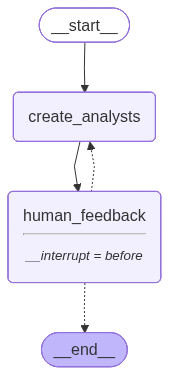

In [7]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class FinancialAnalyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst (e.g., Investment Bank, Hedge Fund).",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst (e.g., Technical Analyst, Fundamental Analyst, Sentiment Analyst).",
    )
    description: str = Field(
        description="Description of the analyst's focus, expertise, and analytical approach.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class AnalystTeam(BaseModel):
    analysts: List[FinancialAnalyst] = Field(
        description="Team of financial analysts with diverse specializations.",
    )

class GenerateAnalystsState(TypedDict):
    stock_symbol: str # Stock symbol to analyze
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[FinancialAnalyst] # Generated analysts
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a team of specialized financial analysts. Follow these instructions:

1. Review the stock symbol:
{stock_symbol}

2. Examine any editorial feedback for analyst creation:

{human_analyst_feedback}

3. Determine the most important analytical perspectives for comprehensive stock analysis.

4. Pick the top {max_analysts} perspectives.

5. Assign one analyst to each perspective with relevant expertise:
   - Technical Analysis (charts, patterns, indicators)
   - Fundamental Analysis (financials, valuations, earnings)
   - Sentiment Analysis (news, social media, market psychology)
   - Macro Analysis (economy, sector trends, regulations)"""

def create_analysts(state: GenerateAnalystsState):
    """ Create financial analysts """

    stock_symbol=state['stock_symbol']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    structured_llm = llm.with_structured_output(AnalystTeam)

    system_message = analyst_instructions.format(stock_symbol=stock_symbol,
                                                            human_analyst_feedback=human_analyst_feedback,
                                                            max_analysts=max_analysts)

    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the analyst team.")])

    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node for interruption """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    return END

builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

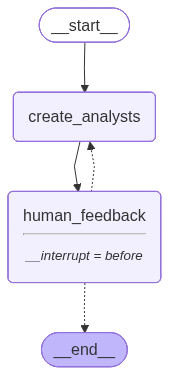

In [8]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a team of specialized financial analysts. Follow these instructions:

1. Review the stock symbol:
{stock_symbol}

2. Examine any editorial feedback for analyst creation:

{human_analyst_feedback}

3. Determine the most important analytical perspectives for comprehensive stock analysis.

4. Pick the top {max_analysts} perspectives.

5. Assign one analyst to each perspective with relevant expertise:
   - Technical Analysis (charts, patterns, indicators)
   - Fundamental Analysis (financials, valuations, earnings)
   - Sentiment Analysis (news, social media, market psychology)
   - Macro Analysis (economy, sector trends, regulations)"""

def create_analysts(state: GenerateAnalystsState):
    """ Create financial analysts """

    stock_symbol=state['stock_symbol']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    structured_llm = llm.with_structured_output(AnalystTeam)

    system_message = analyst_instructions.format(stock_symbol=stock_symbol,
                                                            human_analyst_feedback=human_analyst_feedback,
                                                            max_analysts=max_analysts)

    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the analyst team.")])

    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node for interruption """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    return END

builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [9]:
# Input
max_analysts = 3
stock_symbol = "TSLA"
thread = {"configurable": {"thread_id": "1"}}

# Generate analysts
for event in graph.stream({"stock_symbol":stock_symbol,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Alex Johnson
Affiliation: Hedge Fund
Role: Technical Analyst
Description: Alex specializes in technical analysis with a focus on chart patterns, moving averages, and momentum indicators. He uses advanced software to identify potential entry and exit points for TSLA, leveraging historical price data and volume trends.
--------------------------------------------------
Name: Emily Chen
Affiliation: Investment Bank
Role: Fundamental Analyst
Description: Emily is an expert in fundamental analysis, focusing on Tesla's financial statements, valuation metrics, and earnings reports. She evaluates the company's growth prospects, competitive position, and financial health to provide long-term investment insights.
--------------------------------------------------
Name: Michael Lee
Affiliation: Market Research Firm
Role: Sentiment Analyst
Description: Michael analyzes market sentiment by monitoring news, social media, and investor forums. He assesses the psychological factors influencing TS

In [10]:
state = graph.get_state(thread)
state.next


('human_feedback',)

In [11]:
graph.update_state(thread, {"human_analyst_feedback": None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cf5a2-8a90-6f0b-8002-6659dc4e7576'}}

In [12]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [13]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')
analysts

[FinancialAnalyst(affiliation='Hedge Fund', name='Alex Johnson', role='Technical Analyst', description='Alex specializes in technical analysis with a focus on chart patterns, moving averages, and momentum indicators. He uses advanced software to identify potential entry and exit points for TSLA, leveraging historical price data and volume trends.'),
 FinancialAnalyst(affiliation='Investment Bank', name='Emily Chen', role='Fundamental Analyst', description="Emily is an expert in fundamental analysis, focusing on Tesla's financial statements, valuation metrics, and earnings reports. She evaluates the company's growth prospects, competitive position, and financial health to provide long-term investment insights."),
 FinancialAnalyst(affiliation='Market Research Firm', name='Michael Lee', role='Sentiment Analyst', description="Michael analyzes market sentiment by monitoring news, social media, and investor forums. He assesses the psychological factors influencing TSLA's stock price, identi

## Research Analysis Workflow - STEP 4

In [14]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class AnalysisState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: FinancialAnalyst # Analyst conducting analysis
    analysis: str # Analysis transcript
    sections: list # Final sections for report

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for financial news retrieval.")

In [15]:
question_instructions = """You are a financial analyst conducting research on {stock}.

Your goal is to gather specific, actionable insights about the stock.

1. Actionable: Insights that can inform investment decisions.

2. Specific: Include concrete data, numbers, and recent developments.

Your analytical focus: {goals}

Begin by introducing yourself, then pose your analytical questions.

Continue to drill down until you have comprehensive insights.

When satisfied with your analysis, conclude with: \"Analysis complete!\"

Stay in character throughout your response."""

def generate_question(state: AnalysisState):
    """ Generate analysis question """

    analyst = state["analyst"]
    messages = state["messages"]

    system_message = question_instructions.format(stock=state.get("stock_symbol", "the stock"), goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    return {"messages": [question]}

In [16]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17332\596536740.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


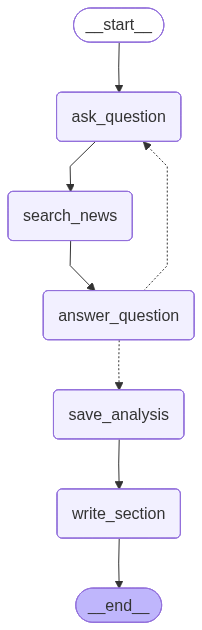

In [17]:
from langchain_core.messages import get_buffer_string

search_instructions = SystemMessage(content=f"""Generate a search query for recent news and information.

Focus on the latest developments, news, and data points relevant to the conversation.

The query should be specific and targeted for financial news sources.""")

def search_news(state: AnalysisState):
    """ Search for financial news """
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    try:
        search_docs = tavily_search.invoke(search_query.search_query)
    except Exception:
        search_docs = []

    if not search_docs:
        formatted_search_docs = ""
    else:
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
                for doc in search_docs
            ]
        )

    return {"context": [formatted_search_docs]}

answer_instructions = """You are a financial information expert.

Analyst focus: {goals}

Answer the analyst's question using this context:

{context}

Guidelines:

1. Use only information from the provided context.

2. Include specific numbers, dates, and data points.

3. Cite sources using [1], [2], etc.

4. List sources at the end:

[1] Source 1
[2] Source 2"""

def generate_answer(state: AnalysisState):
    """ Generate answer """
    analyst = state["analyst"]
    messages = state["messages"]
    context = state.get("context", [])

    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    answer.name = "expert"

    return {"messages": [answer]}

def save_analysis(state: AnalysisState):
    """ Save analysis """
    messages = state["messages"]
    analysis = get_buffer_string(messages)
    return {"analysis": analysis}

def route_messages(state: AnalysisState, name: str = "expert"):
    """ Route between question and answer """

    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    if num_responses >= max_num_turns:
        return 'save_analysis'

    last_question = messages[-2]

    if "Analysis complete" in last_question.content:
        return 'save_analysis'
    return "ask_question"

section_writer_instructions = """You are a financial report writer.

Create a concise, professional section based on analyst research.

1. Analyze the source documents containing analyst research.

2. Use this structure:
## {focus} (section title)

### Key Findings

### Analysis

### Sources

3. Analyst focus: {focus}

4. Key Findings:
- Highlight specific data points and numbers
- Include dates and timeframes
- Note significant trends or changes

5. Analysis:
- Explain implications
- Connect findings to investment perspective
- Maximum 300 words
- Use numbered sources [1], [2]

6. Sources:
- Include all sources used
- Format: [1] URL or source name
- One per line
"""

def write_section(state: AnalysisState):
    """ Write report section """
    analysis = state["analysis"]
    context = state.get("context", [])
    analyst = state["analyst"]

    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this research: {context}")])

    return {"sections": [section.content]}

# Build analysis sub-graph
analysis_builder = StateGraph(AnalysisState)
analysis_builder.add_node("ask_question", generate_question)
analysis_builder.add_node("search_news", search_news)
analysis_builder.add_node("answer_question", generate_answer)
analysis_builder.add_node("save_analysis", save_analysis)
analysis_builder.add_node("write_section", write_section)

analysis_builder.add_edge(START, "ask_question")
analysis_builder.add_edge("ask_question", "search_news")
analysis_builder.add_edge("search_news", "answer_question")
analysis_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_analysis'])
analysis_builder.add_edge("save_analysis", "write_section")
analysis_builder.add_edge("write_section", END)

memory = MemorySaver()
analysis_graph = analysis_builder.compile(checkpointer=memory).with_config(run_name="Conduct Analysis")

display(Image(analysis_graph.get_graph().draw_mermaid_png()))